In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pickle
import csv
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import gdown
import joblib

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import lightgbm as lgb

import eli5
from eli5.sklearn import PermutationImportance

# 코드 셀 실행 후 경고를 무시
# import warnings
# warnings.filterwarnings(action='ignore')

### Load Table

In [2]:
# pickle에서 데이터프레임 다시 불러오기
with open('data.pickle', 'rb') as f:
    df = pickle.load(f)

In [3]:
df

,번지,본번,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,구,동,계약년,계약월,평균공시가격,계약일,date
0,658-1,658.0,개포6차우성,79.97,201712,3,1987,언주로 3,124000.0,0,강남구,개포동,2017,12,120960.000000,8,2017-12-08
1,658-1,658.0,개포6차우성,79.97,201712,4,1987,언주로 3,123500.0,0,강남구,개포동,2017,12,120960.000000,22,2017-12-22
2,658-1,658.0,개포6차우성,54.98,201712,5,1987,언주로 3,91500.0,0,강남구,개포동,2017,12,120960.000000,28,2017-12-28
3,658-1,658.0,개포6차우성,79.97,201801,4,1987,언주로 3,130000.0,0,강남구,개포동,2018,01,120960.000000,3,2018-01-03
4,658-1,658.0,개포6차우성,79.97,201801,2,1987,언주로 3,117000.0,0,강남구,개포동,2018,01,120960.000000,8,2018-01-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,816,816.0,신내우디안1단지,84.65,202307,13,2014,신내역로1길 85,NaN,1,중랑구,Unknown,2023,07,39021.326676,19,2023-07-19
1128090,816,816.0,신내우디안1단지,84.62,202307,12,2014,신내역로1길 85,NaN,1,중랑구,Unknown,2023,07,39021.326676,25,2023-07-25
1128091,816,816.0,신내우디안1단지,101.65,202308,12,2014,신내역로1길 85,NaN,1,중랑구,Unknown,2023,08,39021.326676,27,2023-08-27
1128092,816,816.0,신내우디안1단지,84.94,202309,18,2014,신내역로1길 85,NaN,1,중랑구,Unknown,2023,09,39021.326676,2,2023-09-02


In [4]:
train_path = '../../data/train.csv'
test_path  = '../../data/test.csv'
dt_train = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt_train['is_test'] = 0
dt_test['is_test'] = 1
dt = pd.concat([dt_train, dt_test])

In [5]:
df['large_std_동'] = df['동']
df.drop(['동'], axis=1, inplace=True)

In [6]:
dt['동'] = dt['시군구'].apply(lambda x:x.split()[2])

In [7]:
dt = dt.reset_index()

In [8]:
df['동'] = dt['동']

In [9]:
df.head()

,번지,본번,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,구,계약년,계약월,평균공시가격,계약일,date,large_std_동,동
0,658-1,658.0,개포6차우성,79.97,201712,3,1987,언주로 3,124000.0,0,강남구,2017,12,120960.0,8,2017-12-08,개포동,개포동
1,658-1,658.0,개포6차우성,79.97,201712,4,1987,언주로 3,123500.0,0,강남구,2017,12,120960.0,22,2017-12-22,개포동,개포동
2,658-1,658.0,개포6차우성,54.98,201712,5,1987,언주로 3,91500.0,0,강남구,2017,12,120960.0,28,2017-12-28,개포동,개포동
3,658-1,658.0,개포6차우성,79.97,201801,4,1987,언주로 3,130000.0,0,강남구,2018,01,120960.0,3,2018-01-03,개포동,개포동
4,658-1,658.0,개포6차우성,79.97,201801,2,1987,언주로 3,117000.0,0,강남구,2018,01,120960.0,8,2018-01-08,개포동,개포동


### 년도에따라 동, 구별 statistics 추가

In [10]:
df.drop(['아파트명', '계약일'], axis=1, inplace=True)

In [11]:
df.head(1)

,번지,본번,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,구,계약년,계약월,평균공시가격,date,large_std_동,동
0,658-1,658.0,79.97,201712,3,1987,언주로 3,124000.0,0,강남구,2017,12,120960.0,2017-12-08,개포동,개포동


In [12]:
stats = df.groupby(['계약년', '구'])['target'].agg(['std', 'mean', 'max'])
df = df.join(stats, on=['계약년', '구'], rsuffix='_target')

In [13]:
df['계약년과구에따른std'] = df['std']
df['계약년과구에따른mean'] = df['mean']
df['계약년과구에따른max'] = df['max']
df.drop(['std', 'mean', 'max'], axis=1, inplace=True)
df.head(1)

,번지,본번,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,구,계약년,계약월,평균공시가격,date,large_std_동,동,계약년과구에따른std,계약년과구에따른mean,계약년과구에따른max
0,658-1,658.0,79.97,201712,3,1987,언주로 3,124000.0,0,강남구,2017,12,120960.0,2017-12-08,개포동,개포동,60408.755329,127433.7879,1053000.0


In [14]:
stats = df.groupby(['계약년', '동'])['target'].agg(['std', 'mean', 'max'])
df = df.join(stats, on=['계약년', '동'], rsuffix='_target')

In [15]:
df['계약년과동에따른std'] = df['std']
df['계약년과동에따른mean'] = df['mean']
df['계약년과동에따른max'] = df['max']
df.drop(['std', 'mean', 'max'], axis=1, inplace=True)
df.head(1)

,번지,본번,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,구,...,평균공시가격,date,large_std_동,동,계약년과구에따른std,계약년과구에따른mean,계약년과구에따른max,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max
0,658-1,658.0,79.97,201712,3,1987,언주로 3,124000.0,0,강남구,...,120960.0,2017-12-08,개포동,개포동,60408.755329,127433.7879,1053000.0,32126.755612,108070.249556,260000.0


In [16]:
# '계약년과동에따른std', '계약년과동에따른mean', '계약년과동에따른max'의 null 값을
# '계약년과구에따른std', '계약년과구에따른mean', '계약년과구에따른max'의 값으로 채우기
df['계약년과동에따른std'] = df['계약년과동에따른std'].fillna(df['계약년과구에따른std'])
df['계약년과동에따른mean'] = df['계약년과동에따른mean'].fillna(df['계약년과구에따른mean'])
df['계약년과동에따른max'] = df['계약년과동에따른max'].fillna(df['계약년과구에따른max'])

In [17]:
df.drop(['동', 'large_std_동', '계약월', 'date', '본번', '계약년과구에따른std', '계약년과구에따른mean', '계약년과구에따른max', '계약년'], axis=1, inplace=True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 1128093
Data columns (total 13 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   번지            1128094 non-null  object 
 1   전용면적(㎡)       1128094 non-null  float64
 2   계약년월          1128094 non-null  int64  
 3   층             1128094 non-null  int64  
 4   건축년도          1128094 non-null  int64  
 5   도로명           1128094 non-null  object 
 6   target        1118822 non-null  float64
 7   is_test       1128094 non-null  int64  
 8   구             1128094 non-null  object 
 9   평균공시가격        1128094 non-null  float64
 10  계약년과구에따른std   1128094 non-null  float64
 11  계약년과구에따른mean  1128094 non-null  float64
 12  계약년과구에따른max   1128094 non-null  float64
dtypes: float64(6), int64(4), object(3)
memory usage: 120.5+ MB


### Feature Engineering

### Train

In [19]:
df_train = df.loc[df['is_test']==0, :]
df_test = df.loc[df['is_test']==1, :]

df_train.drop(['is_test'], axis=1, inplace=True)
df_test.drop(['is_test'], axis=1, inplace=True)
print(df_train.shape, df_test.shape)

(1118822, 12) (9272, 12)


In [23]:
drop_df=df_train[df_train['계약년월']>=201501]
drop_df

,번지,전용면적(㎡),계약년월,층,건축년도,도로명,target,구,평균공시가격,계약년과구에따른std,계약년과구에따른mean,계약년과구에따른max
0,658-1,79.97,201712,3,1987,언주로 3,124000.0,강남구,120960.000000,60408.755329,127433.787900,1053000.0
1,658-1,79.97,201712,4,1987,언주로 3,123500.0,강남구,120960.000000,60408.755329,127433.787900,1053000.0
2,658-1,54.98,201712,5,1987,언주로 3,91500.0,강남구,120960.000000,60408.755329,127433.787900,1053000.0
3,658-1,79.97,201801,4,1987,언주로 3,130000.0,강남구,120960.000000,75860.270323,153305.913204,640000.0
4,658-1,79.97,201801,2,1987,언주로 3,117000.0,강남구,120960.000000,75860.270323,153305.913204,640000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
808035,2-1,84.92,201509,3,2008,동망산길 47,49500.0,종로구,59519.951923,27430.916698,48980.566826,190000.0
808038,11-67,52.46,201502,7,1981,서애로1길 34,22700.0,중구,27969.672131,22298.949877,54604.913431,300000.0
808039,11-67,52.46,201506,5,1981,서애로1길 34,25900.0,중구,27969.672131,22298.949877,54604.913431,300000.0
808040,11-67,52.46,201506,6,1981,서애로1길 34,23500.0,중구,27969.672131,22298.949877,54604.913431,300000.0


In [25]:
# 변수 삭제 및 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in drop_df.columns:
    if pd.api.types.is_numeric_dtype(drop_df[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적(㎡)', '계약년월', '층', '건축년도', 'target', '평균공시가격', '계약년과구에따른std', '계약년과구에따른mean', '계약년과구에따른max']
범주형 변수: ['번지', '도로명', '구']


In [27]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm(categorical_columns):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( drop_df[col].astype(str) )
    drop_df[col] = lbl.transform(drop_df[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(df_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    df_test[col] = lbl.transform(df_test[col].astype(str))

100%|██████████| 3/3 [00:00<00:00,  4.10it/s]


In [28]:
y_train = drop_df['target']
X_train = drop_df.drop(['target'], axis=1)

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [35]:
gbm = lgb.LGBMRegressor(n_estimators=2000, max_depth=32, num_leaves=60,
                            feature_fraction=0.8,
                            bagging_fraction=0.9, verbosity=-1)

In [36]:
gbm.fit(
        X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], 
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=100, show_stdv=True)]
        )

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 8601.86	training's l2: 7.3992e+07	valid_1's rmse: 8852.5	valid_1's l2: 7.83667e+07
[200]	training's rmse: 7420.14	training's l2: 5.50585e+07	valid_1's rmse: 7908.43	valid_1's l2: 6.25432e+07
[300]	training's rmse: 6811.26	training's l2: 4.63932e+07	valid_1's rmse: 7447.05	valid_1's l2: 5.54586e+07
[400]	training's rmse: 6404.92	training's l2: 4.1023e+07	valid_1's rmse: 7166.98	valid_1's l2: 5.13656e+07
[500]	training's rmse: 6118.82	training's l2: 3.74399e+07	valid_1's rmse: 6978.67	valid_1's l2: 4.87018e+07
[600]	training's rmse: 5875.48	training's l2: 3.45212e+07	valid_1's rmse: 6825.71	valid_1's l2: 4.65903e+07
[700]	training's rmse: 5696.9	training's l2: 3.24547e+07	valid_1's rmse: 6720.15	valid_1's l2: 4.51604e+07
[800]	training's rmse: 5543.2	training's l2: 3.0727e+07	valid_1's rmse: 6624.75	valid_1's l2: 4.38873e+07
[900]	training's rmse: 5400.82	training's l2: 2.91689e+07	valid_1's rmse: 6552.55

LGBMRegressor(bagging_fraction=0.9, feature_fraction=0.8, max_depth=32,
              n_estimators=2000, num_leaves=60, verbosity=-1)

In [37]:
# import optuna

# def objective(trial):
#     # Define the hyperparameter search space
#     n_estimators = trial.suggest_int('n_estimators', 1000, 5000)
#     max_depth = trial.suggest_int('max_depth', 10, 50)
#     num_leaves = trial.suggest_int('num_leaves', 100, 1000)
#     min_child_samples = trial.suggest_int('min_child_samples', 50, 500)
#     feature_fraction = trial.suggest_float('feature_fraction', 0.5, 1.0)
#     bagging_fraction = trial.suggest_float('bagging_fraction', 0.5, 1.0)
#     lambda_l1 = trial.suggest_float('lambda_l1', 1e-8, 1.0, log=True)  # Increase L1 regularization
#     lambda_l2 = trial.suggest_float('lambda_l2', 1e-8, 1.0, log=True)  # Increase L2 regularization

#     # Create the LGBMRegressor model with the suggested hyperparameters
#     gbm = lgb.LGBMRegressor(n_estimators=n_estimators, max_depth=max_depth, num_leaves=num_leaves,
#                             min_child_samples=min_child_samples, feature_fraction=feature_fraction,
#                             bagging_fraction=bagging_fraction, lambda_l1=lambda_l1, lambda_l2=lambda_l2, verbosity=-1)

#     # Train the model
#     gbm.fit(
#         X_train, y_train, 
#         eval_set=[(X_train, y_train), (X_val, y_val)], 
#         eval_metric='rmse',
#         callbacks=[lgb.early_stopping(stopping_rounds=50),
#                    lgb.log_evaluation(period=100, show_stdv=True)]
#         )
    
#     # Compute the validation RMSE
#     val_rmse = gbm.best_score_['valid_1']['rmse']
#     return val_rmse

# def optimize_hyperparameters(n_trials=100, early_stopping=50, log_evaluation=100):
#     study = optuna.create_study(direction='minimize')
#     study.optimize(objective, n_trials=n_trials)

#     # Get the best hyperparameters
#     best_params = study.best_trial.params

#     # Create the final model with the best hyperparameters
#     best_model = lgb.LGBMRegressor(**best_params)

#     # Train the final model with early stopping and evaluation logging
#     best_model.fit(X_train, y_train,
#                    eval_set=[(X_train, y_train), (X_val, y_val)],
#                    eval_metric='rmse',
#                    callbacks=[lgb.early_stopping(stopping_rounds=early_stopping),
#                               lgb.log_evaluation(period=log_evaluation, show_stdv=True)])

#     return best_model

In [32]:
# best_model = optimize_hyperparameters(n_trials=100)

In [38]:
# 모델 저장.
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(gbm, f)

In [39]:
X_test = df_test.drop(['target'], axis=1)
real_test_pred = gbm.predict(X_test)
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('gu-gong-encoded.csv', index=False)

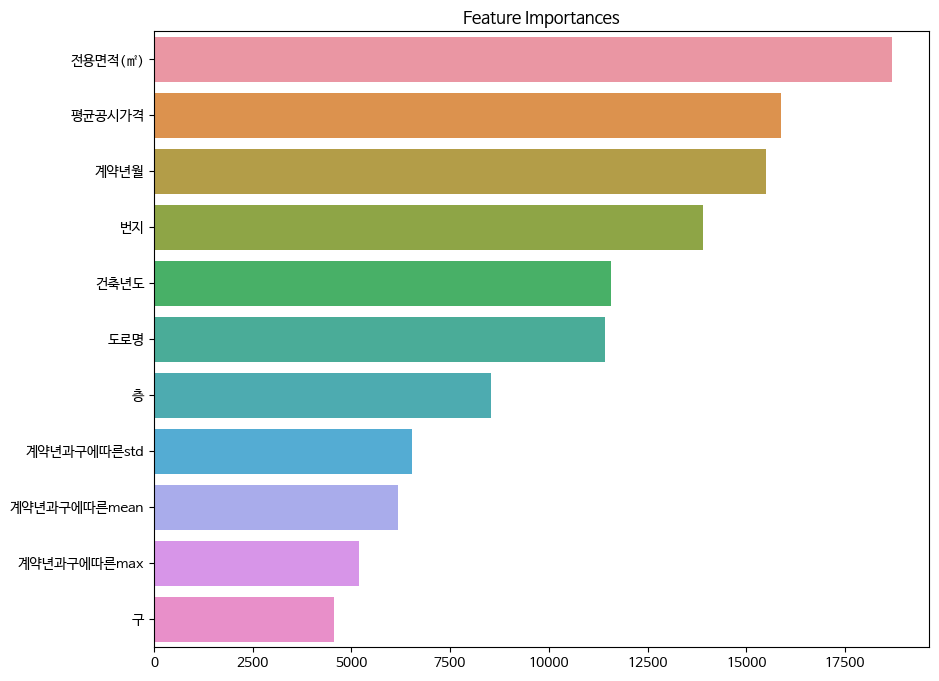

In [32]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(gbm.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [35]:
# preds_df.describe()

NameError: name 'gmb' is not defined

In [40]:
pred=gbm.predict(X_val)
pred

array([51896.61196837, 13311.75399522, 62080.16128006, ...,
       43266.09351208, 94772.12426698, 53387.9443801 ])

In [70]:
val_index = X_val.index
w_col = ['시군구','아파트명','전용면적(㎡)','층','계약년월','건축년도','target']
train_val=dt_train.loc[val_index,w_col]

train_val['pred']= pred
train_val['err'] = train_val['target'] - train_val['pred']
train_val['err'] = train_val['err']

In [73]:
err_ = train_val[train_val.err>=50000]
err_

err_2 = train_val[train_val.err<=-50000]
err_2

,시군구,아파트명,전용면적(㎡),층,계약년월,건축년도,target,pred,err
236220,서울특별시 용산구 이촌동,리버뷰,138.940,8,202203,1970,148000,229714.666292,-81714.666292
203609,서울특별시 강남구 청담동,청담어퍼하우스,197.730,2,202304,2019,600000,707482.146837,-107482.146837
447906,서울특별시 강남구 청담동,씨티1차102동,84.330,7,201612,1992,127750,183625.993297,-55875.993297
215519,서울특별시 서초구 서초동,더샵서초,212.280,25,202212,2006,269000,333702.737755,-64702.737755
236122,서울특별시 용산구 도원동,삼성래미안,59.940,12,202112,2001,70000,125714.964315,-55714.964315
...,...,...,...,...,...,...,...,...,...
436822,서울특별시 용산구 한남동,한남더힐,233.062,3,201812,2011,421000,584427.708104,-163427.708104
240804,서울특별시 강남구 압구정동,현대6차,144.700,13,202012,1978,324000,395787.962138,-71787.962138
506906,서울특별시 서초구 서초동,상지리츠빌,217.520,4,201701,2004,90000,146054.825237,-56054.825237
430193,서울특별시 송파구 신천동,파크리오,84.970,4,201909,2008,90400,162656.199313,-72256.199313


In [74]:
err_[err_['아파트명']=='타워팰리스2']

,시군구,아파트명,전용면적(㎡),층,계약년월,건축년도,target,pred,err
648908,서울특별시 강남구 도곡동,타워팰리스2,223.59,24,201503,2003,350000,297672.518747,52327.481253
239462,서울특별시 강남구 도곡동,타워팰리스2,244.04,48,202106,2003,680000,584433.254152,95566.745848
444446,서울특별시 강남구 도곡동,타워팰리스2,218.40,48,201707,2003,492000,378200.211890,113799.788110
296354,서울특별시 강남구 도곡동,타워팰리스2,223.59,31,201910,2003,430000,377615.561923,52384.438077
547642,서울특별시 강남구 도곡동,타워팰리스2,243.14,52,201604,2003,532000,402291.383281,129708.616719


In [75]:
wt=train_val[train_val['아파트명']=='한남더힐']

<Axes: ylabel='err'>

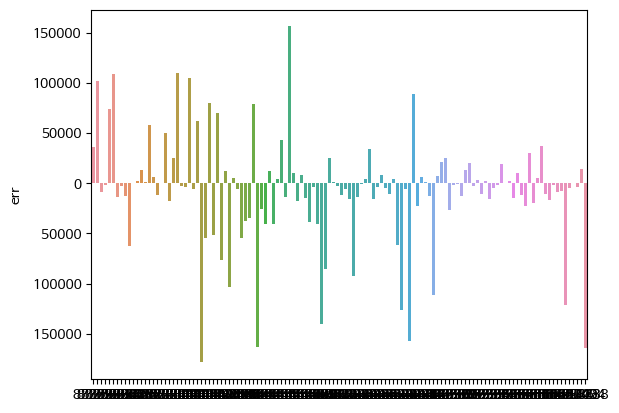

In [76]:

sns.barplot(data=wt, x=wt.index, y='err')

In [77]:
#한남더힐 예측값 1억미만인 친구들

underwt=wt[((wt['err']<=10000) & (wt['err']>=-10000))]
underwt


,시군구,아파트명,전용면적(㎡),층,계약년월,건축년도,target,pred,err
534787,서울특별시 용산구 한남동,한남더힐,233.062,12,201707,2011,438000,443350.945679,-5350.945679
534768,서울특별시 용산구 한남동,한남더힐,177.764,8,201705,2011,310000,314384.601775,-4384.601775
534740,서울특별시 용산구 한남동,한남더힐,208.478,4,201702,2011,360000,360818.494250,-818.494250
534765,서울특별시 용산구 한남동,한남더힐,177.764,6,201705,2011,307000,310662.457086,-3662.457086
635930,서울특별시 용산구 한남동,한남더힐,208.478,6,201605,2011,352000,348463.666626,3536.333374
636040,서울특별시 용산구 한남동,한남더힐,208.478,5,201608,2011,353000,352297.381870,702.618130
436874,서울특별시 용산구 한남동,한남더힐,208.478,5,201906,2011,430000,421405.300532,8594.699468
380498,서울특별시 용산구 한남동,한남더힐,59.700,4,202008,2011,219500,225463.403253,-5963.403253
436837,서울특별시 용산구 한남동,한남더힐,235.312,6,201903,2011,453000,448676.052146,4323.947854
534812,서울특별시 용산구 한남동,한남더힐,177.764,6,201709,2011,315000,308410.900499,6589.099501


In [ ]:
underwt

<Axes: ylabel='err'>

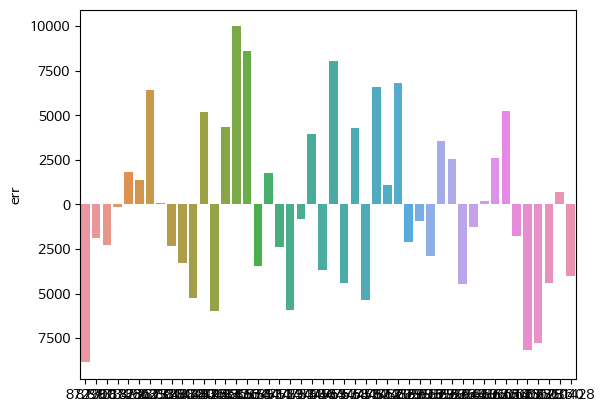

In [66]:
sns.barplot(data=underwt, x=underwt.index, y='err')

In [63]:
wt

,시군구,아파트명,전용면적(㎡),계약년월,건축년도,target,pred,err
534739,서울특별시 용산구 한남동,한남더힐,208.478,201702,2011,350000,363475.147112,-13475.147112
534787,서울특별시 용산구 한남동,한남더힐,233.062,201707,2011,438000,443350.945679,-5350.945679
534768,서울특별시 용산구 한남동,한남더힐,177.764,201705,2011,310000,314384.601775,-4384.601775
534740,서울특별시 용산구 한남동,한남더힐,208.478,201702,2011,360000,360818.494250,-818.494250
436848,서울특별시 용산구 한남동,한남더힐,208.478,201904,2011,375000,388550.417271,-13550.417271
...,...,...,...,...,...,...,...,...
436853,서울특별시 용산구 한남동,한남더힐,243.201,201905,2011,695000,538811.765783,156188.234217
635929,서울특별시 용산구 한남동,한남더힐,208.478,201604,2011,345000,347914.974087,-2914.974087
436889,서울특별시 용산구 한남동,한남더힐,235.312,201907,2011,449000,487704.698215,-38704.698215
534731,서울특별시 용산구 한남동,한남더힐,208.478,201612,2011,385000,390914.611977,-5914.611977


In [79]:
df_test

,번지,전용면적(㎡),계약년월,층,건축년도,도로명,target,구,평균공시가격,계약년과구에따른std,계약년과구에따른mean,계약년과구에따른max
1118822,4682,79.9700,202307,5,1987,6025,NaN,0,120960.000000,112520.254068,208005.081699,900000.0
1118823,4657,108.2017,202308,10,2021,464,NaN,0,155775.000000,112520.254068,208005.081699,900000.0
1118824,4658,161.0000,202307,15,1984,462,NaN,0,182537.777778,112520.254068,208005.081699,900000.0
1118825,4658,133.4600,202308,14,1984,462,NaN,0,182537.777778,112520.254068,208005.081699,900000.0
1118826,4658,104.4300,202308,6,1984,462,NaN,0,182537.777778,112520.254068,208005.081699,900000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,5716,84.6500,202307,13,2014,5423,NaN,24,39021.326676,27142.558383,56865.823529,185000.0
1128090,5716,84.6200,202307,12,2014,5423,NaN,24,39021.326676,27142.558383,56865.823529,185000.0
1128091,5716,101.6500,202308,12,2014,5423,NaN,24,39021.326676,27142.558383,56865.823529,185000.0
1128092,5716,84.9400,202309,18,2014,5423,NaN,24,39021.326676,27142.558383,56865.823529,185000.0
